In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_geom_median__illposed import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
problem_spec['vector_size'] = 100
# problem_spec['translation'] = "b"
problem_spec['translation'] = "rand"
problem_spec['sc_index_set'] = {3,4}
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()

# problem_spec['sc_theta'] = 2
# problem_spec['sc_theta'] = 1
# problem_spec['sc_theta'] = 0.7
# problem_spec['sc_theta'] = 0.5
# problem_spec['sc_theta'] = 0.3
# problem_spec['sc_theta'] = 0.001
problem_spec['sc_theta'] = 0.00001

problem_data['itr_num'] = 1000
# problem_data['itr_num'] = 200
# problem_data['itr_num'] = 100

{'n_node': 6, 'vector_size': 100, 'translation': 'rand', 'sc_index_set': {3, 4}}


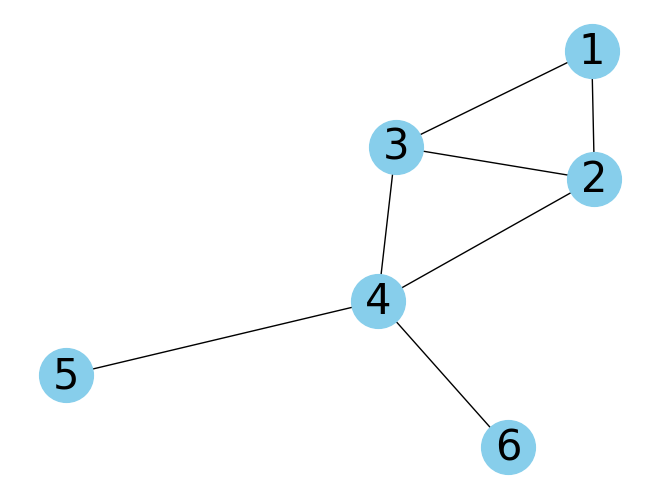

In [3]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True, font_size=30, node_size=1500)
# plt.savefig("plots/graph_n6.pdf")

In [4]:
f_star, x_opt_star = cvx_geom_median(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=2592051.4241510574, np.linalg.norm(x_opt_star)=60.1480555130164


In [5]:
b = problem_data['b']
c = problem_data['c']
Q = problem_data['Q']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
theta = problem_spec['sc_theta']
sc_index_set = problem_spec['sc_index_set']
prox_operators = []
fi_operators = []

for jj in range(n_node):
    Qj = Q[jj]
    bj = b[jj*vector_size : (jj+1)*vector_size]
    cj = c[jj*vector_size : (jj+1)*vector_size]
    if jj in [3, 4]:
        prox_operators += [lambda z, rho, bj=bj, cj=cj, Qj=Qj:  prox_fj_geom_mean_sc(z, rho, bj, cj, Qj, theta=theta)]
        # prox_operators += [lambda z, rho, bj=bj, cj=cj, Qj=Qj, vector_size=vector_size:  cvx_prox_fj_geom_mean_sc(z, rho, bj, cj, Qj, vector_size, theta=theta)]        
        # fi_operators += [lambda x_kj, bj=bj, cj=cj, Qj=Qj: np.linalg.norm((x_kj - bj), ord=2) + theta*np.linalg.norm( Qj @ x_kj - cj, ord=2)**2]
        fi_operators += [lambda x_kj, bj=bj, cj=cj, Qj=Qj: theta*np.linalg.norm( Qj @ x_kj - cj, ord=2)**2]
    else:
        prox_operators += [lambda z, rho, bj=bj:  prox_fj_geom_mean(z, rho, bj)]
        fi_operators += [lambda x_kj, bj=bj: np.linalg.norm((x_kj - bj), ord=2)]

    # Testing the validity of proximals
    z = np.random.randn(vector_size)
    a = 1
    x1 = prox_fj_geom_mean(z, a, bj)
    x2 = cvx_prox_fj_geom_mean(z, a, bj, vector_size)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

    x1 = prox_fj_geom_mean_sc(z, a, bj, cj, Qj, theta=theta)
    x2 = cvx_prox_fj_geom_mean_sc(z, a, bj, cj, Qj, vector_size, theta=theta)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-3

In [6]:
for j in sc_index_set:
    U, s, V = np.linalg.svd(Q[j])
    print([np.max(s), np.average(s), np.min(s)])

[90000.00000000004, 30250.84006734008, 0.9999999999984868]
[90000.00000000012, 30250.840067340076, 0.9999999999987982]


## Find best parameter for DADMM

In [7]:
find_best = True

start, end, space = 0.0001, 0.0005, 0.00001
# start, end, space = 0.0001, 0.001, 0.0001
# start, end, space = 0.1, 4, 0.05
# start, end, space = 0.5, 4, 0.5
# start, end, space = 0.5, 10, 0.5
# start, end, space = 10, 100, 10

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        R = round(r, 6)
        admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=False, freq=200)
        # new_val = sum(admm_f_reldiff[50:150]) / 100
        # new_val = sum(admm_f_reldiff[50:350]) / 300
        new_val = sum(admm_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_R :", R,  ", new best_value :", new_val)
            best_value = new_val
            best_R = R

print("best_R :", best_R)

new best_R : 0.0001 , new best_value : 3.276297923757852e-06
new best_R : 0.00011 , new best_value : 6.679711406057567e-07
new best_R : 0.00012 , new best_value : 2.870140012416109e-07
new best_R : 0.00015 , new best_value : 2.686891265782116e-07
new best_R : 0.00016 , new best_value : 1.8890789190154676e-07
new best_R : 0.00017 , new best_value : 1.2964777185112148e-07
new best_R : 0.00018 , new best_value : 8.804341746777857e-08
new best_R : 0.00019 , new best_value : 5.9192509404752555e-08
new best_R : 0.0002 , new best_value : 4.430723935109648e-08
new best_R : 0.00021 , new best_value : 4.0443333665040603e-08
best_R : 0.00021


In [8]:
R = best_R
# R = 0.6
# R = 0.0001
# R = 100
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.15192268088653987, err_opt_reldiff[-1]=0.942861520684677
ii=200, f_reldiff[-1]=5.646958354530479e-06, err_opt_reldiff[-1]=0.001464213388883583
ii=400, f_reldiff[-1]=8.111916670109293e-09, err_opt_reldiff[-1]=5.9489613856743536e-06
ii=600, f_reldiff[-1]=3.0731059085464744e-11, err_opt_reldiff[-1]=2.2962915872279914e-08
ii=800, f_reldiff[-1]=1.6168473922704925e-13, err_opt_reldiff[-1]=8.4725522904367e-09
ii=999, f_reldiff[-1]=7.185988410091078e-16, err_opt_reldiff[-1]=8.570956187393262e-09


## Find best parameter of P-EXTRA

In [9]:
# apply P-EXTRA 
find_best = True

start, end, space = 0.00001, 0.0001, 0.00001
# start, end, space = 0.0001, 0.001, 0.0001
# start, end, space = 0.001, 0.01, 0.001
# start, end, space = 0.01, 0.1, 0.01
# start, end, space = 0.05, 2, 0.05
# start, end, space = 0.5, 10, 0.5
# start, end, space = 2, 20, 2
# start, end, space = 10, 100, 10
# start, end, space = 100, 1000, 100

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        rho = round(r, 5)
        problem_data['rho'] = rho
        # print("Testing rho :", r)
        pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_dgeom_median(None, problem_spec, problem_data, 
                                                                                                    network_data, x_opt_star, f_star, 
                                                                                                    printing=False, freq=200)
        # new_val = sum(pg_f_reldiff[50:350]) / 300
        new_val = sum(pg_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_rho :", rho, "new best_value :", new_val)
            best_value = new_val
            best_rho = rho

print("best_rho :", best_rho)

new best_rho : 1e-05 new best_value : 0.11419884165061625
new best_rho : 2e-05 new best_value : 0.010939461666592692
new best_rho : 3e-05 new best_value : 0.001390430382768697
new best_rho : 4e-05 new best_value : 0.00015986536693233752
new best_rho : 5e-05 new best_value : 1.5621385213401262e-05
best_rho : 5e-05


In [10]:
# apply P-EXTRA 
problem_data['rho'] = best_rho
# problem_data['rho'] = 1000000000
pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_dgeom_median(None, problem_spec, problem_data, 
                                                                                            network_data, x_opt_star, f_star, 
                                                                                            printing=True, freq=200)

ii=0, f_reldiff[-1]=143.77690969747889, err_opt_reldiff[-1]=0.5790359567351839
ii=200, f_reldiff[-1]=0.0005036079261586799, err_opt_reldiff[-1]=0.003869762451829317
ii=400, f_reldiff[-1]=1.0013946016866515e-05, err_opt_reldiff[-1]=0.00021747699852368797
ii=600, f_reldiff[-1]=3.549651380593938e-07, err_opt_reldiff[-1]=1.274627327433363e-05
ii=800, f_reldiff[-1]=1.40608443613916e-08, err_opt_reldiff[-1]=7.484685732371636e-07
ii=999, f_reldiff[-1]=8.166671027398822e-10, err_opt_reldiff[-1]=4.4371559198404687e-08


## DADMM-C

In [293]:
# params={"R":3, "Inductance":3, "Capacitance":8/3, "h":1.842939271898937}
# params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
# params={"R":1, "Inductance":6, "Capacitance":8, "h":5.13906193644284}
# params={"R":2, "Inductance":3, "Capacitance":0.5, "h":0.71692315906863}
# params={"R":2, "Inductance":3, "Capacitance":4, "h":2.321989931}
# params={"R":2, "Inductance":1, "Capacitance":1, "h":0.665836807162538}
# params={"R":1.5, "Inductance":4.5, "Capacitance":6, "h":3.50141019655701}
# params={"R":1, "Inductance":8, "Capacitance":8, "h":5.5409883749567}
# params={"R":0.8, "Inductance":2, "Capacitance":15, "h":3.515416990114254}
# params={"R":0.5, "Inductance":4, "Capacitance":16, "h":2.764408907848405}

### not verified parameters
# params={"R":3, "Inductance":3, "Capacitance":8/3, "h":2.4} # Work well for theta=0.3
# params={"R":2, "Inductance":3, "Capacitance":4, "h":3} # Work great for theta=0.5
# params={"R":2, "Inductance":3.1, "Capacitance":47, "h":3} 
# params={"R":2, "Inductance":3.3, "Capacitance":17, "h":3}  # Dont work well for theta=0.5
# params={"R":2, "Inductance":3, "Capacitance":3, "h":3} # Work well for theta=0.5
# params={"R":2, "Inductance":3, "Capacitance":4, "h":2.1785158094003885} # from solver
# params={"R":0.85, "Inductance":2, "Capacitance":14, "h":4.8} # not bad for theta=1, good for theta=2
# params={"R":0.8, "Inductance":2, "Capacitance":12, "h":4.5} # good for theta=1
# params={"R":1.3, "Inductance":2, "Capacitance":8, "h":3.5}
# params={"R":1.2, "Inductance":2, "Capacitance":14, "h":4.7} # works no bad for theta=2


# params={"R":0.00022, "Inductance":0.00011, "Capacitance":4545.45, "h":0.5} # equals to DADMM
# params={"R":0.00022, "Inductance":0.00008, "Capacitance":3900, "h":0.5} 
# params={"R":0.00022, "Inductance":0.00022, "Capacitance":10000, "h":1.3} 


# params={"R":0.00022, "Inductance":0.00011, "Capacitance":4000, "h":0.5} # equals to DADMM

# params={"R":0.0003, "Inductance":0.00022, "Capacitance":8500, "h":1.3}  # best

# params={"R":0.0004, "Inductance":0.00022, "Capacitance":6000, "h":1} # work better
# params={"R":0.0004, "Inductance":0.00022, "Capacitance":12000, "h":1} # work better
# params={"R":0.0004, "Inductance":0.0003, "Capacitance":20000, "h":1.4} # work better
# params={"R":0.0004, "Inductance":0.0004, "Capacitance":20000, "h":1.9} # work better



# params={"R":0.0001, "Inductance":0.0001, "Inductance_S":0.0001, "Capacitance":20000, "h":0.5} # equals to DADMM

# params={"R":0.00021, "Inductance":0.000105, "Inductance_S":0.000105, "Capacitance":4761, "h":0.5} # equals to DADMM

# params={"R":0.0003, "Inductance":0.00039, "Inductance_S":0.00039, "Capacitance":8666, "h":1.3} # Same as DADMM

# params={"R":0.0003, "Inductance":0.0002, "Inductance_S":0.00023, "Capacitance":14000, "h":1.5} # quite good

# params={"R":0.0003, "Inductance":0.0002, "Inductance_S":0.00023, "Capacitance":11000, "h":1.5} # quite good

# params={"R":0.0004, "Inductance":0.0006, "Inductance_S":0.0006, "Capacitance":7500, "h":1.5} # Same as DADMM

# params={"R":0.0004, "Inductance":0.0004, "Inductance_S":0.0004, "Capacitance":8000, "h":1.7} # Not that much good

# params={"R":0.0003, "Inductance":0.00022, "Inductance_S":0.00022, "Capacitance":8300, "h":1.3} # Works better

# params={"R":0.0003, "Inductance":0.00015, "Inductance_S":0.00022, "Capacitance":8300, "h":1.3} # best

# params={"R":0.0003, "Inductance":0.00022, "Inductance_S":0.0004, "Capacitance":8300, "h":1.5}  #soso



# params={"R":0.001, "Inductance":0.0005, "Inductance_S":0.0009, "Capacitance":2000, "h":1.2}  # worse, when R=0.0002is the best



dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff  = co.dadmm("cir_dadmm_c2", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.06166094942419595, err_opt_reldiff[-1]=0.9358757436362837
ii=200, f_reldiff[-1]=7.906548808559991e-07, err_opt_reldiff[-1]=0.00011915198980120227
ii=400, f_reldiff[-1]=1.116700802431051e-10, err_opt_reldiff[-1]=3.999462422466311e-08
ii=600, f_reldiff[-1]=9.539399614395906e-14, err_opt_reldiff[-1]=8.55779695648893e-09
ii=800, f_reldiff[-1]=5.389491307568309e-16, err_opt_reldiff[-1]=8.571440537808683e-09
ii=999, f_reldiff[-1]=0.0, err_opt_reldiff[-1]=8.571444338457743e-09


## Plots

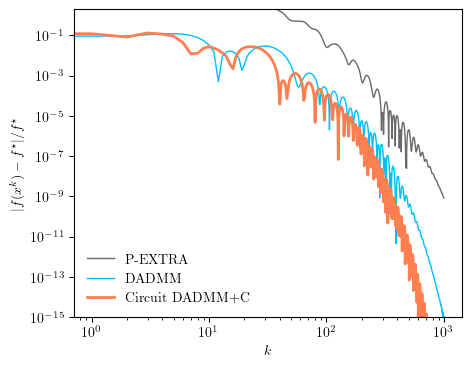

In [294]:
fname = "n6_circuit_dadmm_c_theta%s"%str(problem_spec['sc_theta'])

co.plot_methods([pg_f_reldiff,admm_f_reldiff,dadmm_c_f_reldiff],
                ['P-EXTRA', 'DADMM','Circuit DADMM+C'], 1e-15, 2e-0, fname)

In [295]:
np.where(np.array(admm_f_reldiff) < 1e-5)[0][0]

106

In [296]:
np.where(np.array(dadmm_c_f_reldiff) < 1e-5)[0][0]

80